# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [18]:
import cv2 
import mediapipe as mp # se te corto el audio es verdad 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
#import time
#import threading
#import pyttsx3
from collections import Counter
#from tensorflow.keras.models import load_model

In [19]:
#def speak_async(engine, text):
#    threading.Thread(target=lambda: (engine.say(text), engine.runAndWait())).start()
num_camara=0

## 2. INICIALIZAR MEDIAPIPE

In [20]:
# Inicialización de MediaPipe
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils


pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1  # Reducir la complejidad
)

hands = mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2,
    model_complexity=0  # Complejidad mínima
)

# Variables globales
data_dir = "sign_language_data_JUPYTER"
data_dir_video = "sign_language_data_JUPYTER_videos"
os.makedirs(data_dir, exist_ok=True)
os.makedirs(data_dir_video, exist_ok=True)

sequence_length = 30  # Frames por secuencia
n_pose_landmarks = 33 * 3
n_hand_landmarks = 21 * 3
total_landmarks = n_pose_landmarks + (n_hand_landmarks * 2)

## 3. PROCESAR LOS FRAMES

In [21]:
def process_frame(frame):
    """Procesa un frame y retorna los resultados de pose y manos"""
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pose_results = pose.process(rgb_frame)
    hands_results = hands.process(rgb_frame)
    return pose_results, hands_results

## 4. EXTRAER LOS LANDMARKS

In [22]:
def extract_landmarks(pose_results, hands_results):
    """Extrae y normaliza los landmarks de pose y manos."""
    landmarks = []

    if pose_results.pose_landmarks:
        pose_landmarks = [[lm.x, lm.y, lm.z] for lm in pose_results.pose_landmarks.landmark]
        landmarks.extend(np.array(pose_landmarks).flatten())
    else:
        landmarks.extend([0] * n_pose_landmarks)

    hand_landmarks_list = []
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks[:2]:  # Máximo 2 manos
            hand_points = [[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]
            hand_landmarks_list.extend(np.array(hand_points).flatten())

    # Rellenar con ceros si no se detectan ambas manos
    while len(hand_landmarks_list) < n_hand_landmarks * 2:
        hand_landmarks_list.extend([0] * n_hand_landmarks)

    landmarks.extend(hand_landmarks_list)
    landmarks = np.array(landmarks)

    # Normalización
    if np.any(landmarks):
        landmarks = (landmarks - np.mean(landmarks)) / np.std(landmarks)
    return landmarks


## 5. RECOLLECION DE DATOS 

In [23]:
def collect_data(data_dir_video, data_dir, sign_name, sequence_length):
    """Recolecta secuencias de movimiento para una seña específica y guarda el video de los landmarks"""
    sign_dir = os.path.join(data_dir, sign_name)
    sign_dir_video = os.path.join(data_dir_video, f"{sign_name}")
    os.makedirs(sign_dir, exist_ok=True)
    os.makedirs(sign_dir_video, exist_ok=True)

    cap = cv2.VideoCapture(num_camara)  # Cambiar índice si usas DroidCam u otra cámara
    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara")
        return

    total_sequences = int(input("Número de secuencias a recolectar (recomendado: 20-30): "))

    print("\nInstrucciones:")
    print(f"1. Cada secuencia grabará {sequence_length} frames de movimiento")
    print("2. Presiona ESPACIO para iniciar cada secuencia")
    print("3. Realiza el movimiento completo de la seña")
    print("4. La grabación se detendrá automáticamente")
    print("5. Presiona ESC para cancelar")

    sequence_count = 0
    frame_count = 0
    is_recording = False
    current_sequence = []

    while sequence_count < total_sequences:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        blank_frame = np.zeros_like(frame)
        pose_results, hands_results = process_frame(frame)

        # Dibujar landmarks
        if pose_results.pose_landmarks:
            mp_draw.draw_landmarks(blank_frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        if hands_results.multi_hand_landmarks:
            for hand_landmarks in hands_results.multi_hand_landmarks:
                mp_draw.draw_landmarks(blank_frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Mostrar mensajes
        if is_recording:
            cv2.putText(frame, f"Grabando secuencia {sequence_count + 1}...", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            landmarks = extract_landmarks(pose_results, hands_results)
            current_sequence.append(landmarks)
            frame_count += 1

            if frame_count >= sequence_length:
                # Guardar la secuencia
                sequence_data = np.array(current_sequence)
                np.save(os.path.join(sign_dir, f"sequence_{sequence_count}.npy"), sequence_data)
                print(f"Secuencia {sequence_count + 1}/{total_sequences} guardada")
                sequence_count += 1
                frame_count = 0
                is_recording = False
                current_sequence = []

        cv2.imshow("Recolección de Datos", frame)
        cv2.imshow("Landmarks", blank_frame)

        key = cv2.waitKey(1) & 0xFF
        if key == 32 and not is_recording:  # Espacio para iniciar grabación
            is_recording = True
            current_sequence = []
            frame_count = 0
        elif key == 27:  # ESC para salir
            break

    cap.release()
    cv2.destroyAllWindows()


## 6. ENTRENAMIENTO DEL MODELO

In [24]:
def train_model(data_dir, sequence_length, total_landmarks, model_file):
    """Entrena el modelo utilizando CNN, LSTM y Transformers."""
    
    if not os.listdir(data_dir):
        print("No hay datos para entrenar")
        return

    X = []
    y = []
    class_names = sorted(os.listdir(data_dir))

    print("Cargando secuencias...")
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        samples = [f for f in os.listdir(class_dir) if f.startswith('sequence_')]
        print(f"Clase {class_name}: {len(samples)} secuencias")

        for sample_file in samples:
            sample_path = os.path.join(class_dir, sample_file)
            sequence = np.load(sample_path)
            X.append(sequence)
            y.append(class_idx)

    X = np.array(X)
    y = tf.keras.utils.to_categorical(y)

    # Normalización de los datos
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Definir dimensiones del modelo
    input_shape = (sequence_length, total_landmarks)
    num_classes = len(class_names)

    # Arquitectura del modelo
    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenamiento
    history = model.fit(
        X, y,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    model.save(model_file)
    print(f"\nModelo guardado en {model_file}")

    # Visualización del entrenamiento
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title('Precisión del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

### modelo que funciona cheto:

´´´python 

inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)


## 7. EVALUACION DEL MODELO

### CARGA DEL MODELO

In [25]:
last_spoken_word = None  # Variable global para almacenar la última palabra pronunciada

def load_model(model_file):
    """Carga el modelo previamente entrenado."""
    if not os.path.exists(model_file):
        print("No se encontró el modelo entrenado")
        return None
    #Cargar el modelo entrenado
    return tf.keras.models.load_model(model_file)

### CARGA DE LA INFORMACION DE PRUEBA

In [26]:
def load_test_data(data_dir, sequence_length):
    """Carga y prepara los datos de prueba."""
    class_names = sorted(os.listdir(data_dir))

    # Crear conjunto de prueba
    print("Cargando datos de prueba...")
    X_test = []
    y_test = []

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        samples = [f for f in os.listdir(class_dir) if f.startswith('sequence_')]

        # Seleccionar el 20% de las secuencias como prueba
        test_samples = samples[:int(0.2 * len(samples))]
        for sample_file in test_samples:
            sample_path = os.path.join(class_dir, sample_file)
            sequence = np.load(sample_path)
            X_test.append(sequence)
            y_test.append(class_idx)

    X_test = np.array(X_test)
    y_test = tf.keras.utils.to_categorical(y_test)
    return X_test, y_test, class_names

### PRUEBA DEL MODELO

In [27]:
def evaluate_model(model, X_test, y_test):
    """Evalúa el modelo en los datos de prueba."""
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nPérdida en prueba: {loss:.4f}")
    print(f"Precisión en prueba: {accuracy:.2%}")

    # Mostrar métricas globales
    plt.figure(figsize=(6, 4))
    plt.bar(["Pérdida", "Precisión"], [loss, accuracy], color=['blue', 'green'])
    plt.title("Métricas globales en prueba")
    plt.ylim(0, 1)
    plt.ylabel("Valor")
    plt.show()

In [28]:
def preprocess_sequence(sequence):
    """Normaliza una secuencia de landmarks con manejo de errores."""
    sequence = np.array(sequence)
    if sequence.size == 0:
        return np.zeros_like(sequence)  # Evitar errores
    
    mean = np.nanmean(sequence, axis=0)  # Ignorar NaNs
    std = np.nanstd(sequence, axis=0)
    std[std == 0] = 1  # Evitar divisiones por cero
    
    return (sequence - mean) / std


In [29]:
from filterpy.kalman import KalmanFilter

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([0., 0.])  # Estado inicial
kf.F = np.array([[1., 1.], [0., 1.]])  # Matriz de transición de estado
kf.H = np.array([[1., 0.]])  # Matriz de observación
kf.P *= 1000.  # Covarianza inicial
kf.R = 5  # Ruido de medición
kf.Q = np.array([[0.1, 0.], [0., 0.1]])  # Ruido del proceso

def apply_kalman_filter(prediction):
    kf.predict()
    kf.update(prediction)
    return kf.x[0]

In [30]:
from scipy.signal import savgol_filter

def smooth_landmarks(landmarks, window_length=5, polyorder=2):
    """Suaviza los landmarks usando un filtro Savitzky-Golay."""
    smoothed_landmarks = np.apply_along_axis(
        lambda x: savgol_filter(x, window_length, polyorder),
        axis=0,
        arr=landmarks
    )
    return smoothed_landmarks

### PRUEBA DEL MODELO EN TIEMPO REAL

In [31]:
def evaluate_realtime(model_file, data_dir, sequence_length, mp_draw, mp_pose, mp_hands, num_camara):
    """Realiza la evaluación en tiempo real usando una cámara."""
    model = load_model(model_file)
    if model is None:
        return
    class_names = sorted(os.listdir(data_dir))

    cap = cv2.VideoCapture(num_camara)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara.")
        return

    current_sequence = []
    predictions_buffer = []

    prediction_confidences = []
    prediction_stabilities = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        pose_results, hands_results = process_frame(frame)

        if hands_results.multi_hand_landmarks:
            landmarks = extract_landmarks(pose_results, hands_results)
            current_sequence.append(landmarks)

            if len(current_sequence) > sequence_length:
                current_sequence.pop(0)

            if len(current_sequence) == sequence_length:
                sequence_data = np.array([preprocess_sequence(current_sequence)])
                prediction = model.predict(sequence_data, verbose=0)
                predicted_class = class_names[np.argmax(prediction[0])]
                confidence = np.max(prediction[0])

                predictions_buffer.append(predicted_class)
                if len(predictions_buffer) > 10:
                    predictions_buffer.pop(0)

                most_common = Counter(predictions_buffer).most_common(1)[0]
                stable_prediction = most_common[0]
                stability = most_common[1] / len(predictions_buffer)

                if stability > 0.5 and confidence > 0.7:
                    cv2.putText(frame, f"Seña: {stable_prediction}", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    cv2.putText(frame, f"Confianza: {confidence:.2%}", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Evaluación", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

    if prediction_confidences:
        avg_confidence = np.mean(prediction_confidences)
        avg_stability = np.mean(prediction_stabilities)

        print(f"\nPromedio de confianza: {avg_confidence:.2%}")
        print(f"Promedio de estabilidad: {avg_stability:.2%}")

        plt.figure(figsize=(6, 4))
        plt.plot(prediction_confidences, label="Confianza")
        plt.title("Confianza de Predicciones en Tiempo Real")
        plt.xlabel("Frame")
        plt.ylabel("Confianza")
        plt.legend()
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.plot(prediction_stabilities, label="Estabilidad")
        plt.title("Estabilidad de Predicciones en Tiempo Real")
        plt.xlabel("Frame")
        plt.ylabel("Estabilidad")
        plt.legend()
        plt.show()

### EVALUA EL MODELO

In [32]:
def evaluate_on_test_set(model, test_data, class_names):
    """Evalúa el modelo en un conjunto de test y muestra métricas como precisión, recall y F1-score."""
    y_true = []
    y_pred = []

    for sequence, label in test_data:
        sequence_data = np.array([sequence])
        prediction = model.predict(sequence_data, verbose=0)
        predicted_class = np.argmax(prediction[0])

        y_true.append(label)
        y_pred.append(predicted_class)

    # Calcular métricas
    from sklearn.metrics import classification_report
    print("\nMétricas del conjunto de test:")
    print(classification_report(y_true, y_pred, target_names=class_names))

## 8. MENU

### DEFINICION

In [33]:
def main():
    #data_dir = "data"  # Directorio para los datos recolectados
    data_dir = "sign_language_data_JUPYTER"
    model_file = "sign_language_model.h5"
    sequence_length = 90  # Longitud de la secuencia para cada muestra
    num_camara = 0  # Índice de la cámara

    # Crear el directorio si no existe
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Ver detección de pose y manos")
        print("2. Recolectar datos de señas")
        print("3. Entrenar modelo")
        print("4. Evaluar en tiempo real")
        print("5. Salir")
        
        option = input("\nSeleccione una opción: ")
        
        if option == "1":
            cap = cv2.VideoCapture(num_camara)
            cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
            cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                frame = cv2.flip(frame, 1)
                pose_results, hands_results = process_frame(frame)
                # Dibuja los landmarks si se detectan
                if pose_results.pose_landmarks:
                    mp_draw.draw_landmarks(frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                if hands_results.multi_hand_landmarks:
                    for hand_landmarks in hands_results.multi_hand_landmarks:
                        mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                cv2.imshow("Detección de Pose y Manos", frame)

                if cv2.waitKey(1) & 0xFF == 27:  # ESC para salir
                    break

            cap.release()
            cv2.destroyAllWindows()
        
        elif option == "2":
            sign_name = input("Nombre de la seña a recolectar: ")
            collect_data(data_dir_video, data_dir, sign_name, sequence_length)
        
        elif option == "3":
            train_model(data_dir, sequence_length, total_landmarks, model_file)
        
        elif option == "4":
            evaluate_realtime(model_file, data_dir, sequence_length, mp_draw, mp_pose, mp_hands, num_camara)
        
        elif option == "5":
            print("¡Hasta luego!")
            break
        
        else:
            print("Opción no válida.")




# MOSTRAR EL MENU


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Ver detección de pose y manos
2. Recolectar datos de señas
3. Entrenar modelo
4. Evaluar en tiempo real
5. Salir
Cargando secuencias...
Clase Hola: 30 secuencias
Clase OK: 30 secuencias
Clase construir: 30 secuencias
Epoch 1/50


3/3 [==============================] - 6s 501ms/step - loss: 2.0215 - accuracy: 0.1944 - val_loss: 1.8916 - val_accuracy: 0.6667
Epoch 2/50
3/3 [==============================] - 0s 68ms/step - loss: 1.8918 - accuracy: 0.6667 - val_loss: 1.7483 - val_accuracy: 0.9444
Epoch 3/50
3/3 [==============================] - 0s 68ms/step - loss: 1.7786 - accuracy: 0.8889 - val_loss: 1.6361 - val_accuracy: 0.9444
Epoch 4/50
3/3 [==============================] - 0s 81ms/step - loss: 1.6939 - accuracy: 0.9167 - val_loss: 1.5333 - val_accuracy: 1.0000
Epoch 5/50
3/3 [==============================] - 0s 74ms/step - loss: 1.6169 - accuracy: 0.9306 - val_loss: 1.4471 - val_accuracy: 1.0000
Epoch 6/50
3/3 [==========

c:\Users\juanp\Desktop\Python\.conda\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


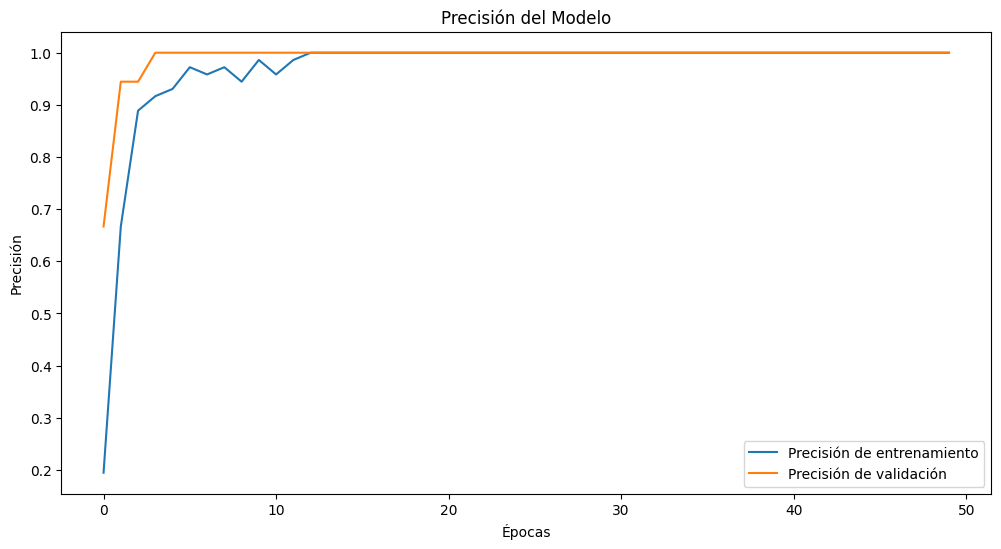

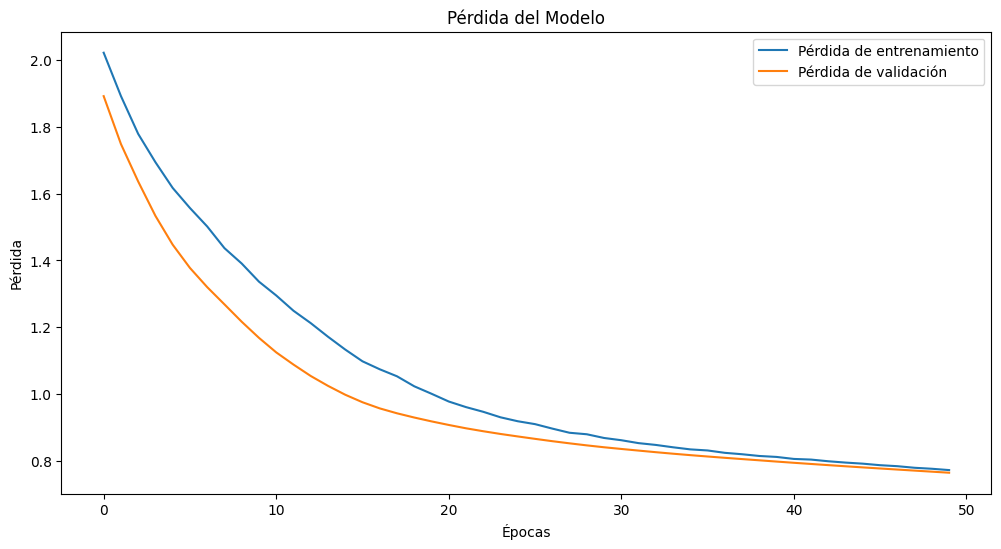


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Ver detección de pose y manos
2. Recolectar datos de señas
3. Entrenar modelo
4. Evaluar en tiempo real
5. Salir

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Ver detección de pose y manos
2. Recolectar datos de señas
3. Entrenar modelo
4. Evaluar en tiempo real
5. Salir
¡Hasta luego!


In [34]:
if __name__ == "__main__":
    main()